# Inquéritos DEISI

[Link](https://deisi.ulusofona.pt/inqueritos/_73N1TW)

![img](img/inquerito.png)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.datasets import co2

# Univariate Time Series Models Using Statistical Methods

* We've seen some different models for forecast
* Other methods and models can be used, depending on the time series nature
    - univariate x multivariate
    - seasonal x non-seasonal
    - stationary x non-stationary
    - linear x nonlinear
* These factors will vary by industry, domain and the study's objective

There are some popular statistical modeling methods:
* exponential smoothing
* ARIMA
* SARIMA
* Vector Autoregressive
* Other variants of these models

## Data

### 1. Load data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.api import (kpss, adfuller,
                                 seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import statsmodels as sm
from pathlib import Path


warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]

In [4]:
life_file = 'data/life_expectancy_birth.csv'
milk_file = 'data/milk_production.csv'

life = pd.read_csv(life_file,
                   index_col='year',
                   parse_dates=True,
                   skipfooter=1)

milk = pd.read_csv(milk_file,
                   index_col='month',
                   parse_dates=True)


In [5]:
life.head()

,value
year,
1960-01-01,69.123902
1961-01-01,69.760244
1962-01-01,69.149756
1963-01-01,69.248049
1964-01-01,70.311707


In [6]:
milk.head()

,production
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: title={'center': 'Monthly Milk Production'}, xlabel='month'>

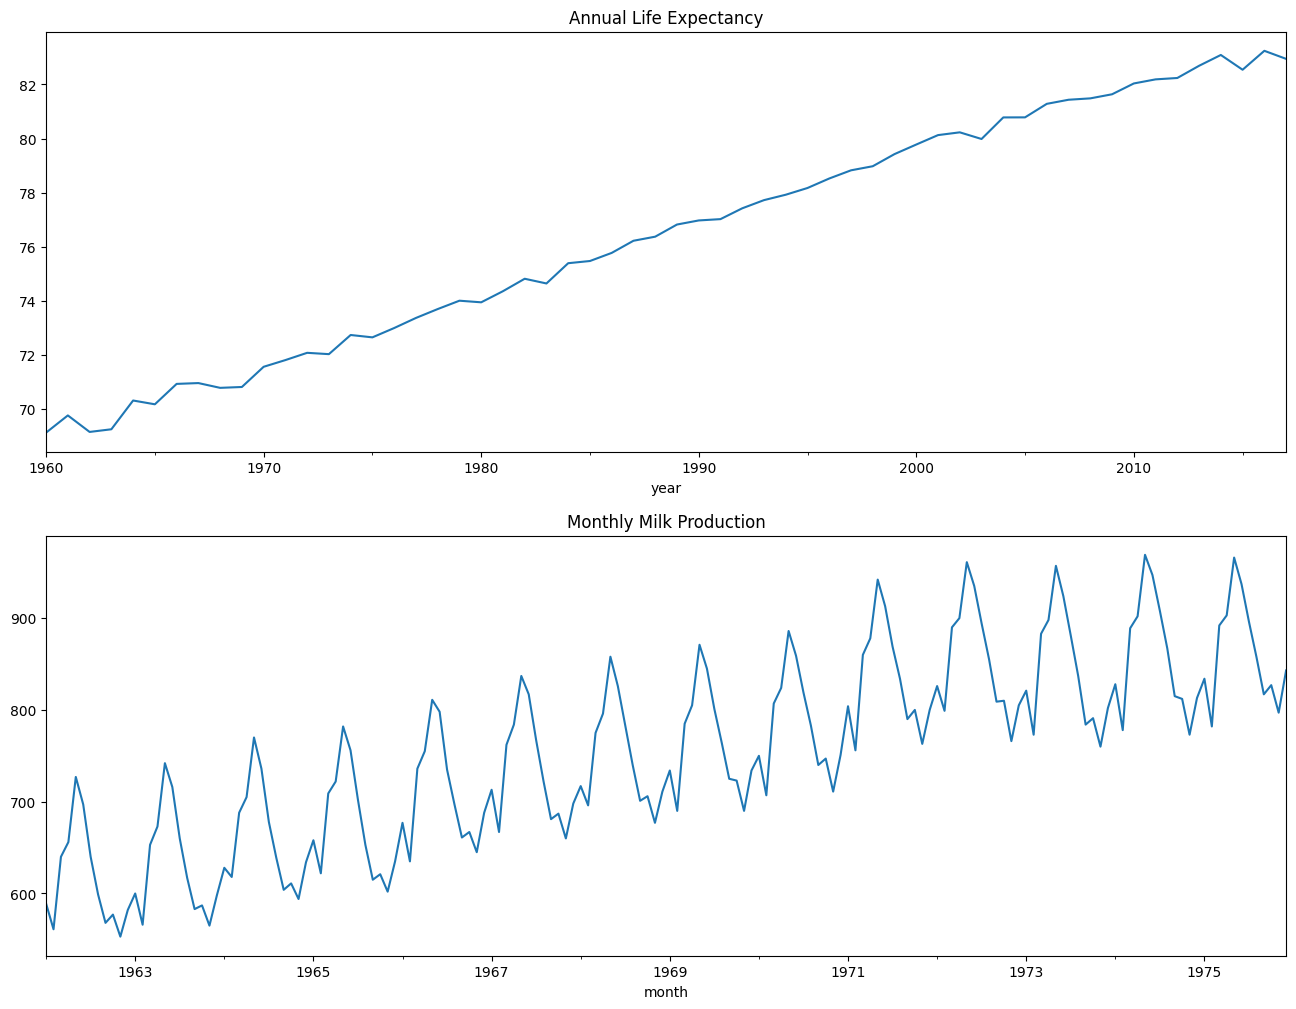

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
life.plot(title='Annual Life Expectancy',
                        legend=False, ax=ax[0])
milk.plot(title='Monthly Milk Production',
                        legend=False, ax=ax[1])

* life
    - positive trend
    - no seasonality
    - anual life expectancy records at birth from 1960 to 2018
    - original dataset has data for country
    - this dataset is for `world` values
* milk
    - positive trend
    - repeating seasonality (every summer)
    - monthly data from January 1962 to December 1975 (168)


### 2. Split into train/test

In [8]:
def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [9]:
test_split = 0.15
milk_train, milk_test = split_data(milk, test_split)
life_train, life_test = split_data(life, test_split)


train: 143 , test: 25
train: 49 , test: 9


### 3. Check for stationarity

* Several time series forecasting techniques assume **stationarity**
* **Stationary** time series imples that specific statistical properties do not vary over time and remain steady.
* **Non-stationary** time series is more complex to model due to the dynamic nature and variations over time

There are different approaches for defining stationary, we will focus on the definition below:
* A stationary time series is defined as a time series with a constant mean ($\mu$), a constant variance ($\sigma^2$), and a consistenc covariance (or autocorrelation) between identical distanced periods (lags).
* Generally: time series with trend or seasonality can be considered non-stationary
* We can decide if a time-series is stationary by analysing the plots
* Or we can use statistical tests

Statistical test: Augmented Dickey-Fuller (ADF) and Kwiatkowski-Phillips-Schimidt-Shin (KPSS)
* Based on linear regression
* A type of statistical hypothesis test
* The **null hypothesis** for ADF states that there is a unit root in the time series, and thus, it is non-sationary
* The KPSS has the opposite null hypothesis, which assumes the time series is stationary.
* You will need to interpret the test results to decide whether you can reject or fail to reject the null hypothesis.

In [10]:
# 1. Start by importint the adfuller and kpss functions

from statsmodels.tsa.stattools import adfuller, kpss

# 2. Define a function to summarize the results

def print_results(output, test='adf'):

    pval = output[1]
    test_score = output[0]
    lags = output[2]

    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'

    output_dict = {
    'Test Statistic': test_score,
    'p-value': pval,
    'Numbers of lags': lags,
    'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value

    return pd.Series(output_dict, name=test)

In [11]:
co2_df = co2.load_pandas().data
co2_df = co2_df.ffill()

<Axes: title={'center': 'CO2 emission'}>

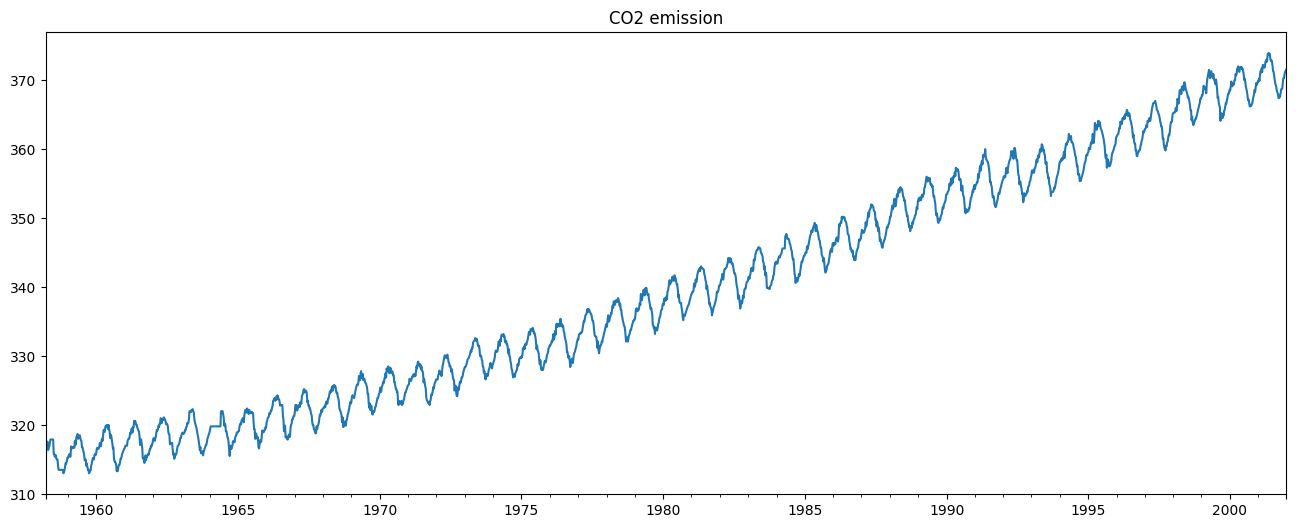

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
co2_df.plot(title='CO2 emission',
                        legend=False, ax=ax)

In [13]:
# run both the kpss and adfuller test
adf_output = adfuller(co2_df)
kpss_output = kpss(co2_df)

In [14]:
pd.concat([
print_results(adf_output, 'adf'),
print_results(kpss_output, 'kpss')
], axis=1)


,adf,kpss
Test Statistic,0.046051,7.649196
p-value,0.962179,0.01
Numbers of lags,27,29
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.433252,0.739
Critical Value (5%),-2.862822,0.463
Critical Value (10%),-2.567452,0.347
Critical Value (2.5%),NaN,0.574


* For the ADF, the p-value is at 0.96, which is greater than 0.05, so you cannot reject the null hypothesis --> non-stationary
* For KPSS, the p-value is at 0.01, which is less than 0.05, so you reject the null hypothesis --> non-stationary

* We need to have stationarity for some models.
* We can achieve stationarity by removing trend (detrending) and seasonality effects.
* After each transformation, you have to run the stationarity test again and compare the results.

We can use the functions below to check the series after each transformation.

In [15]:
def check_stationarity(df):
    kps = kpss(df)
    adf = adfuller(df)

    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Stationary', 'Non-stationary'

    if adf_pv < 0.05:
        # Reject ADF Null Hypothesis
        adfh = 'Stationary'
    if kpss_pv < 0.05:
        # Reject KPSS Null Hypothesis
        kpssh = 'Non Stationary'
    return (kpssh, adfh)

In [16]:
def plot_comparison(methods, plot_type='line'):
    n = len(methods) // 2 + 1
    fig, ax = plt.subplots(n,2, sharex=True, figsize=(20,10))
    for i, method in enumerate(methods):
        method.dropna(inplace=True)
        name = [n for n in globals() if globals()[n] is method]
        v, r = i // 2, i % 2

        kpss_s, adf_s = check_stationarity(method)

        method.plot(kind=plot_type,
                    ax=ax[v,r],
                    legend=False,
                    title=f'{name[0].upper()} KPSS={kpss_s}, ADF={adf_s}')
        ax[v,r].title.set_size(14)
        method.rolling(52).mean().plot(ax=ax[v,r], legend=False)


Transformations:

1. First-order differencing: Also known as detrending
$$y_t = y_t - y_{t-1}$$
2. Second-order differencing: Useful if seasonality exists or if the first-order differencing was insufficient.Differencing twice.
3. Subtracting moving average (rolling window)
4. Log transformation
5. Remove trend component using `seasonal_decompose`

In [17]:
# using first order differencing (detrending)
first_ord_diff = co2_df.diff().dropna()

# using second order differencing
second_ord_diff = co2_df.diff().diff().dropna()

# differencing to remove seasonality
diseasonalize = co2_df.diff(52).dropna()

# using rolling mean
rolling_mean = co2_df.rolling(window=52).mean()
subt_roll_mean = co2_df - rolling_mean

# log transform
log_transform = np.log(co2_df)

# Square root transform
square_root = np.sqrt(co2_df)

# using seasonal_decompose to remove trend
decomp = seasonal_decompose(co2_df)
sd_detrend = (decomp.observed - decomp.trend)



# combine the methods into a list
methods = [first_ord_diff, second_ord_diff,
           diseasonalize, subt_roll_mean,
           log_transform, square_root,
           sd_detrend]

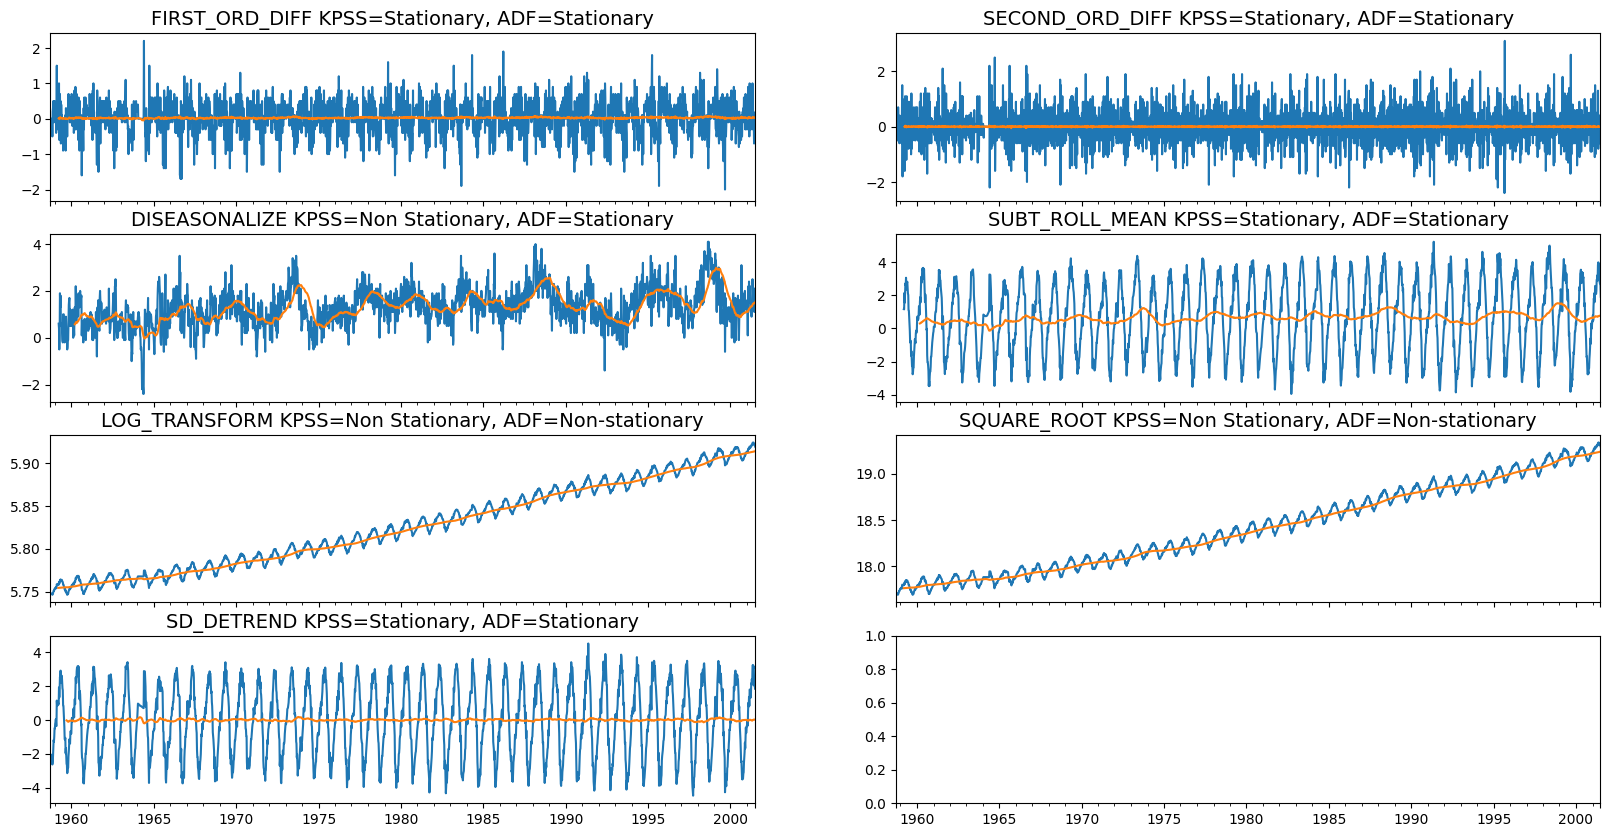

In [18]:
plot = plot_comparison(methods)
warnings.simplefilter(action='ignore')
#plt.savefig('images/fig_9.20.png', bbox_inches='tight')


* You don't want to over-difference your time series --> over-differenced data are less accurate

Back to our example..

* We will use the ADF test to evaluate the stationarity
* We will validate the results with ACF and PACF plots

In [19]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

### 4. Hyperparameter Tuning

#### ARIMA and SARIMA Models

**AR - AutoRegressive models**
- We forecast the variable of interest using a linear combination of predictors
$$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$$
- We refer ti this as an AR(p), an autoregressive model of order $p$

**MA - Moving average models**
- Uses past forecast errors in a regression-like model
$$y_{t} = c + \varepsilon_t + \theta_{1}\varepsilon_{t-1} + \theta_{2}\varepsilon_{t-2} + \dots + \theta_{q}\varepsilon_{t-q}, $$
- We refer to this as an MA(q) model, a moving average model of order q

**ARMA**
- AutoRegressive Moving Avarage
- ARMA(p, q)
- combines AR(p) and MA(q)

**ARIMA**
- If we combine AR with MA and differencing, we obtain an ARIMA model
- ARIMA - AutoRegressive Integrated Moving Average
- "integration" is the reverse of differencing

$$y'_{t} = c + \phi_{1}y'_{t-1} + \cdots + \phi_{p}y'_{t-p}
     + \theta_{1}\varepsilon_{t-1} + \cdots + \theta_{q}\varepsilon_{t-q} + \varepsilon_{t} $$
- ARIMA(p, d, q)
    - $p = $ order of the autoregressive part
    - $d = $ degree of first differencing involved
    - $q = $ order of the moving average part


**SARIMA - Seasonal ARIMA models**
- Formed by including additional seasonal terms in the ARIMA models
- $m = $ the seasonal period (e.g., number of observations per year)
- We use uppercase notation for the seasonal parts of the model
- lower case notation for the non-seasonal parts

![img](img/sarima.jpg)

**Parameters and Hyperparameters**
- When training a ARIMA model we produce a set of parameters called coefficients
- the (p, q, d) in ARIMA are callede hyperparameters
- hyperparameters = set manually and influence the model parameters

**Plotting ACF and PACF**
* When using AR, MA, ARIMA or SARIMA we need to determine the type of time series model that is most suitable for your data and the values of the parameters
* The ACF and PACF can be plotted to help you identify if the time series process is an AR, MA, or an ARMA
* ARMA and ARIMA differ in the stationarity assumption
* ARMA assumes stationarity
* ARIMA does not



In [20]:
# lets use the life expectancy data


<Axes: xlabel='year'>

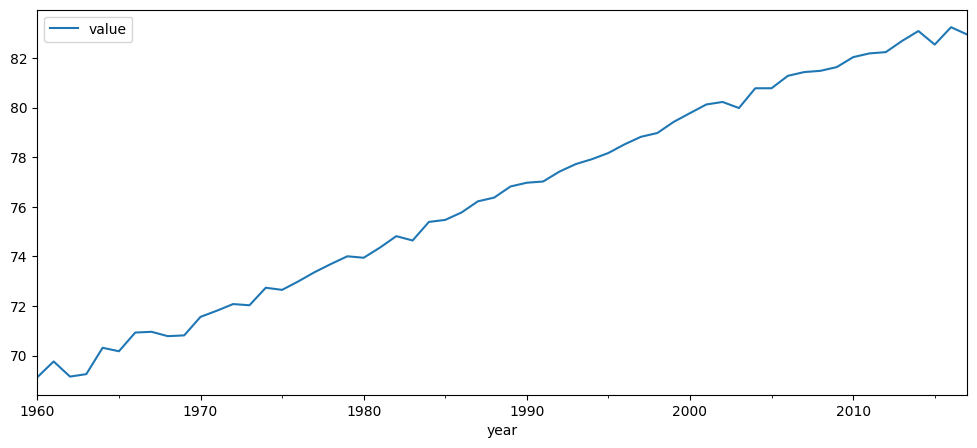

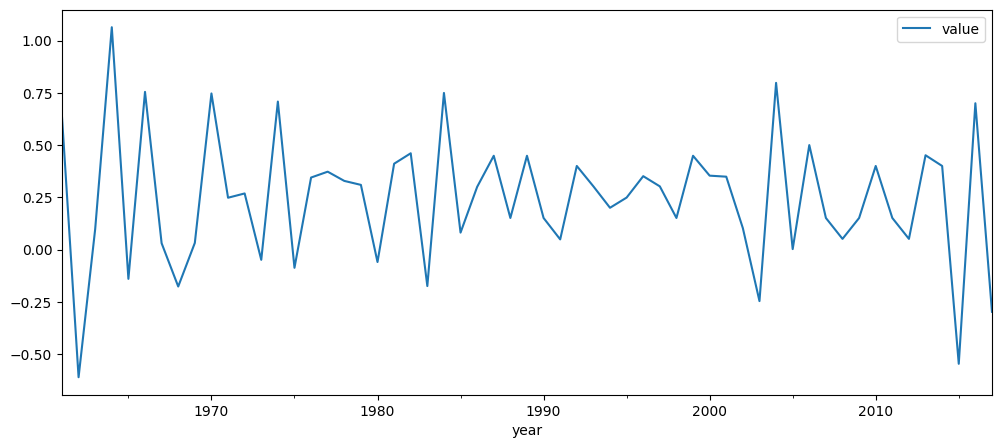

In [21]:
life.plot()
life_diff = life.diff().dropna()
life_diff.plot()

In [22]:
check_stationarity(life_diff)

'Stationary	 p-value:2.5350543281690394e-14 	 lags:1


('Stationary', 2.5350543281690394e-14)

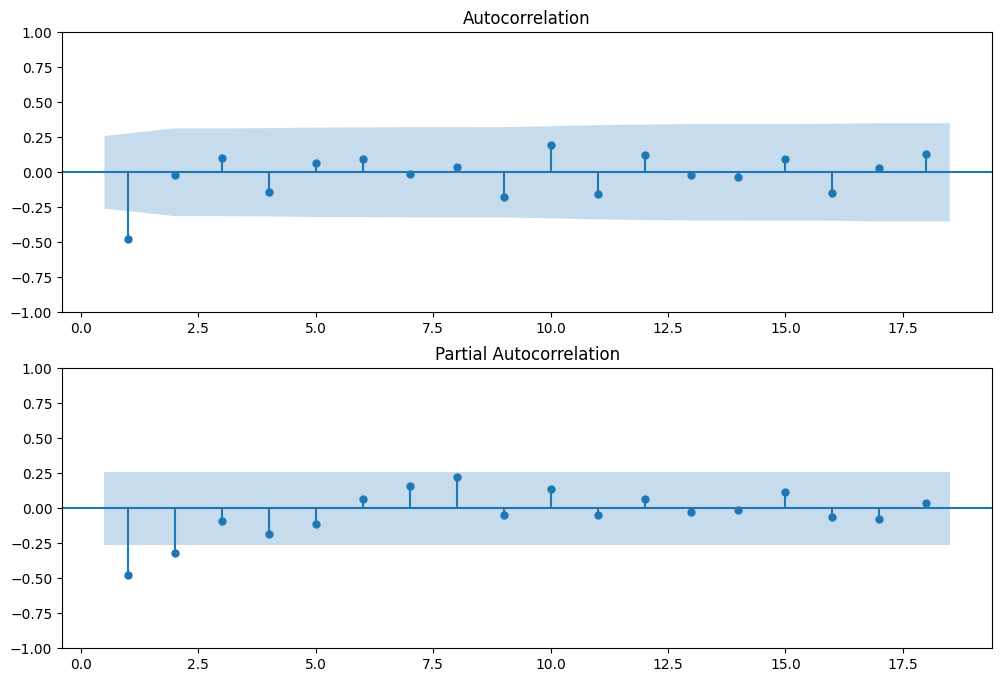

In [23]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1])
#plt.savefig('images/fig_10.2.png', bbox_inches='tight', dpi=300)
plt.show()


* The ACF plot shows a significant spike at lag 1.
* Significance = when a lag goes above or below the shaded area
* Shaded area = confidence interval (95% by default)
* This indicates a moving avarege of order one MA(1)
* The PACF shows a gradual decay with oscillation
* Generally, if PACF showes gradual decay, it indicates a moving avarege model
* ARMA(0, 1) or ARIMA(0, 1, 1)

In [24]:
# now the milk dataset
milk_diff_12 = milk.diff(12).dropna()
check_stationarity(milk_diff_12)

'Non-Stationary	 p-value:0.16079880527711332 	 lags:12


('Non-Stationary', 0.16079880527711332)

In [25]:
milk_diff_12_1 = milk.diff(12).diff(1).dropna()
check_stationarity(milk_diff_12_1)

'Stationary	 p-value:1.8654234318788898e-05 	 lags:11


('Stationary', 1.8654234318788898e-05)

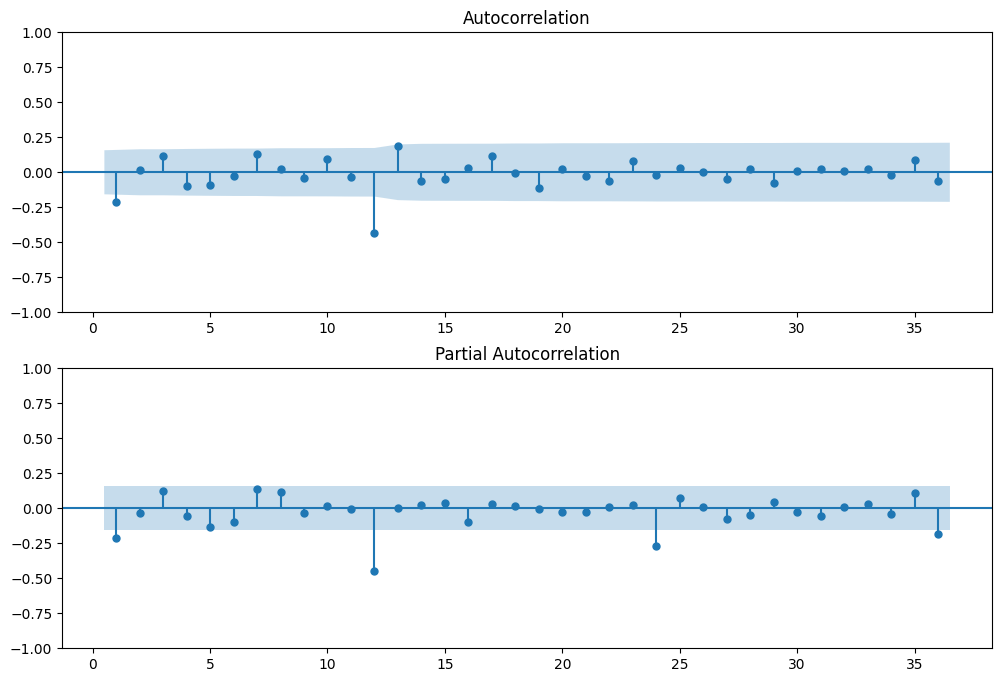

In [26]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(milk_diff_12_1, zero=False, ax=ax[0], lags=36)
plot_pacf(milk_diff_12_1, zero=False, ax=ax[1], lags=36)
# plt.savefig('images/fig_10.3.png', bbox_inches='tight', dpi=300)
plt.show()

* Milk production series is more complex
* It has strong trends and seasonality
* For seasonal order $P$ and $Q$ we should observe spikes or behaviors at lags s, 2s, 3s, where $s$ is the number of periods in a season
* Milk production, $s=12$. We should observe significance at 12, 24, 36 and so on.
* ACF shows a significant spike at lag 1, which represents the non-seasonal order for the MA process as $q=1$
* The spike at lag 12 represents the seasonal order for the MA process $Q = 1$
* There is a cut-off righ after lag 1, then a spike at lag 12, followed by a cut-off --> indicates a moving average model MA(1) for the non-seasonal component and an MA(1) for the seasonal component.
* ARIMA(0, 1, 1)(0, 1, 1, 12)

We will start with non-seasonal ARIMA, then move to SARIMA

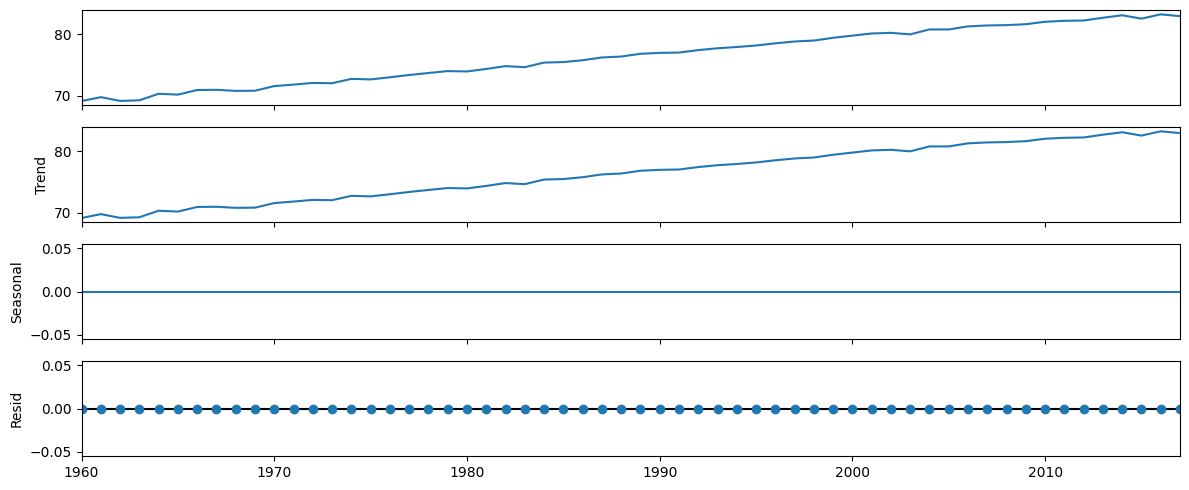

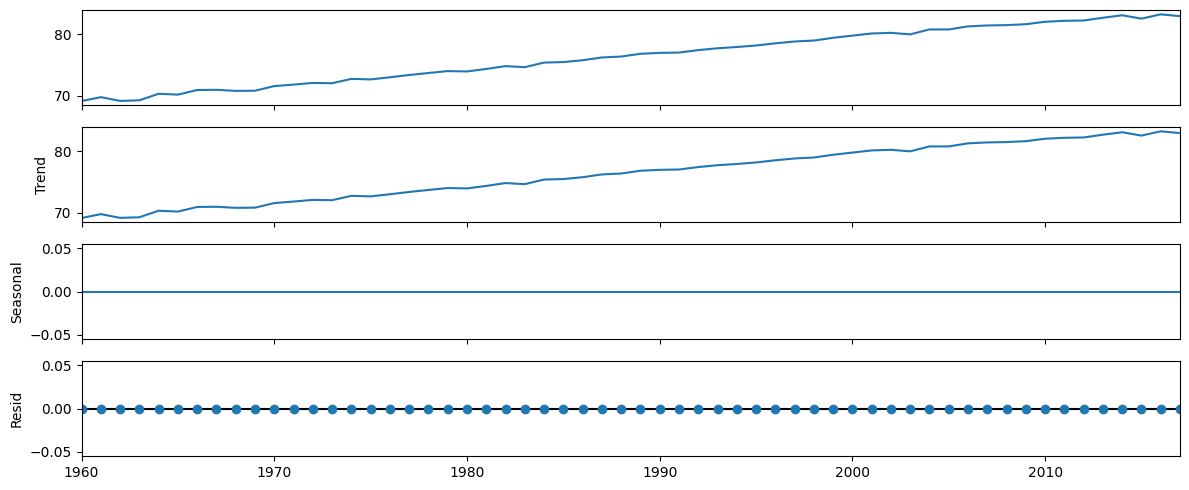

In [27]:
decomposed = seasonal_decompose(life)
decomposed.plot()

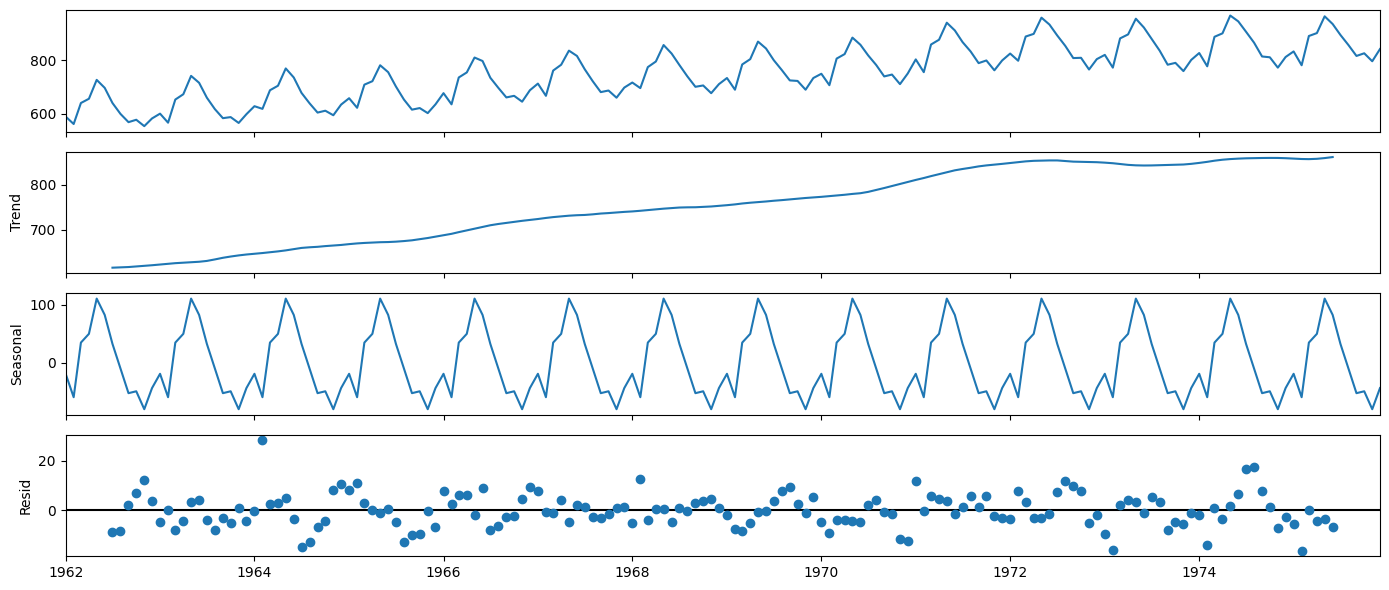

In [28]:
plt.rcParams["figure.figsize"] = [14, 6]
decomposed = seasonal_decompose(milk, period=12)
decomposed.plot(); plt.show()

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(life_train, order=(0,1,1))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   49
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -24.094
Date:                Tue, 04 Jun 2024   AIC                             52.188
Time:                        18:29:27   BIC                             55.931
Sample:                    01-01-1960   HQIC                            53.603
                         - 01-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0822      0.204      0.403      0.687      -0.318       0.482
sigma2         0.1598      0.033      4.812      0.000       0.095       0.225
Ljung-Box (L1) (Q):                  12.50   Jarque-

We will need to validate the model's residuals to determine if the ARIMA model captured the signals in the time series

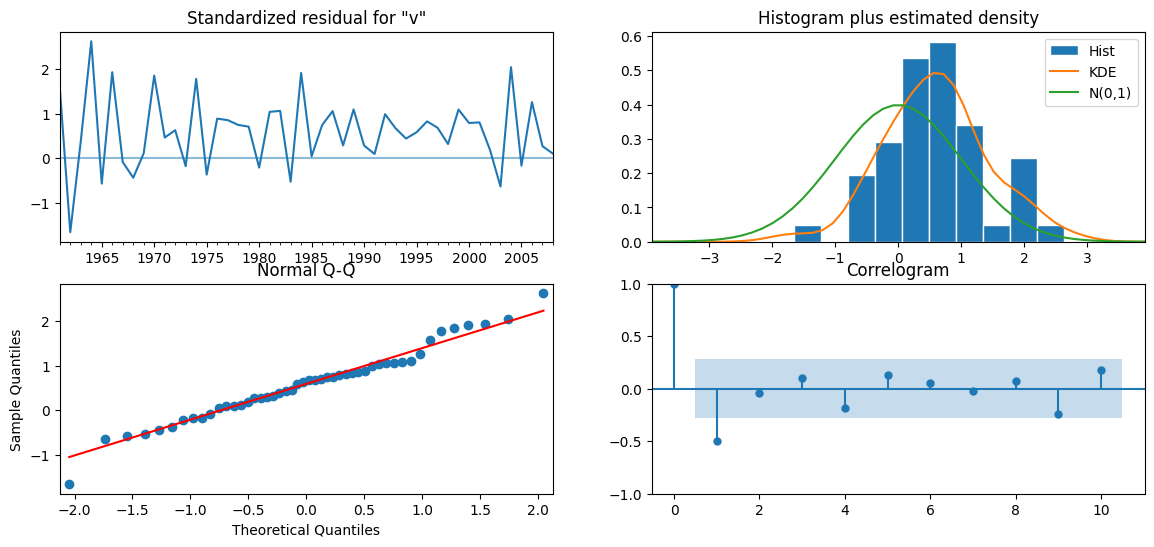

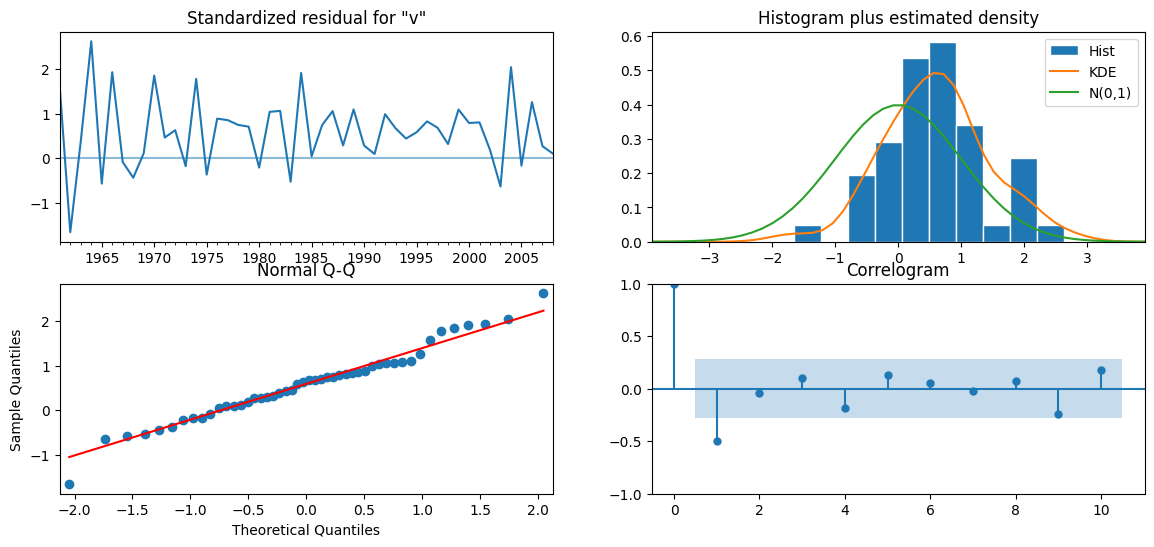

In [30]:
results.plot_diagnostics()

In [32]:
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    # plt.show()
    return ax

<Axes: xlabel='year'>

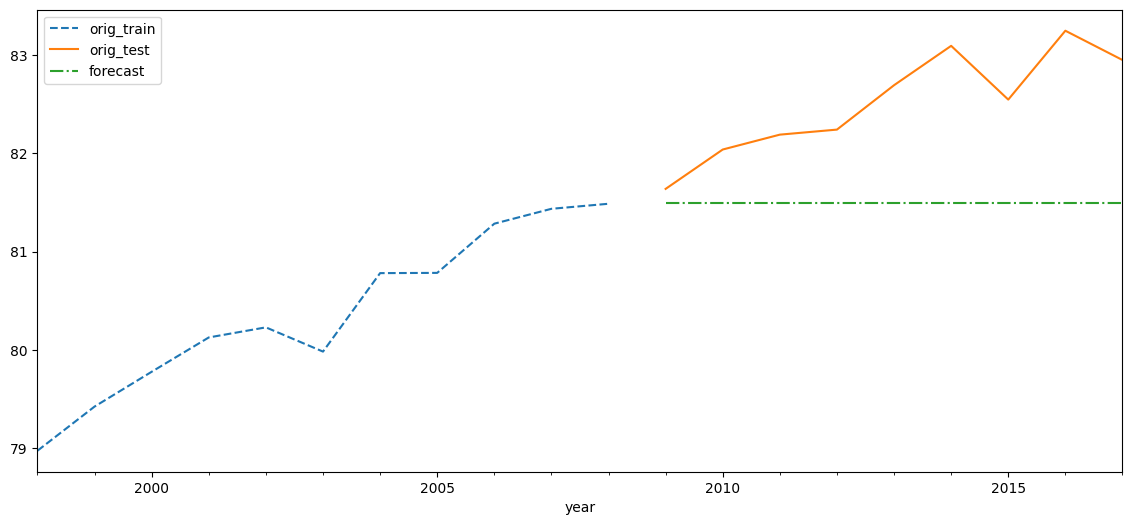

In [33]:
plot_forecast(results, '1998', life_train, life_test)

Sometimes it isn't easy to identify if the time series is an MA or AR process or find the optimal values for $p$ and $q$.
We can perform a grid search to try different combinations of the hiperparameters

In [35]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]
    return combo

pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv])
score = {}
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(life_train, order=(p,d,q))
    res = m.fit()
    y = life_test.values.ravel()
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic,
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

In [36]:
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [37]:
get_best_model(score, 'AIC')

Best model: 8 with lowest AIC score: 7.063691797277956


In [38]:
pd.DataFrame(score).T.sort_values(by='AIC').reset_index()

,index,order,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
0,8,"(0, 2, 2)",7.063692,12.614135,7.621831,0.060355,0.499043,0.004917,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,14,"(1, 1, 2)",8.958804,16.443609,9.889037,0.05911,0.488735,0.00479,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,17,"(1, 2, 2)",9.063586,16.464177,10.015967,0.060416,0.499545,0.004924,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,26,"(2, 2, 2)",10.140968,19.391706,11.604382,0.061522,0.508684,0.005066,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,23,"(2, 1, 2)",10.960085,20.31609,12.388656,0.05918,0.489317,0.004798,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,25,"(2, 2, 1)",19.426078,26.826668,20.378459,0.061464,0.50842,0.004841,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,16,"(1, 2, 1)",23.412154,28.962597,23.970294,0.053817,0.44527,0.003886,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,22,"(2, 1, 1)",25.536364,33.021168,26.466596,0.051992,0.430158,0.003744,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
8,7,"(0, 2, 1)",31.684308,35.384603,31.957035,0.049044,0.4059,0.003405,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,13,"(1, 1, 1)",33.8092,39.422803,34.354654,0.044771,0.370511,0.003096,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


5. Forecast analysis

**AIC - Akaike Information Criterion**

The AIC is a metric that aims to find a balance between a model's maximum likelihood and a model's simplicity
* Overly complex models can sometimes overfit
* The AIC score penalizes as the number of parameters increases since they increase complexity

$$ AIC = 2k -2ln(L^*)$$
$2k$ is the penalty term

**BIC - Bayesian Information Criteria**
* Verty similar to AIC
* Higher penalty on the model's complexity
$$BIC = kln(n) -2ln(L^*)$$

In [39]:
model = ARIMA(life_train, order=(0,2,2))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   49
Model:                 ARIMA(0, 2, 2)   Log Likelihood                  -0.532
Date:                Tue, 04 Jun 2024   AIC                              7.064
Time:                        18:43:03   BIC                             12.614
Sample:                    01-01-1960   HQIC                             9.152
                         - 01-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9443      5.694     -0.341      0.733     -13.105       9.216
ma.L2          0.9978      5.838      0.171      0.864     -10.444      12.440
sigma2         0.0492      0.289      0.170      0.8

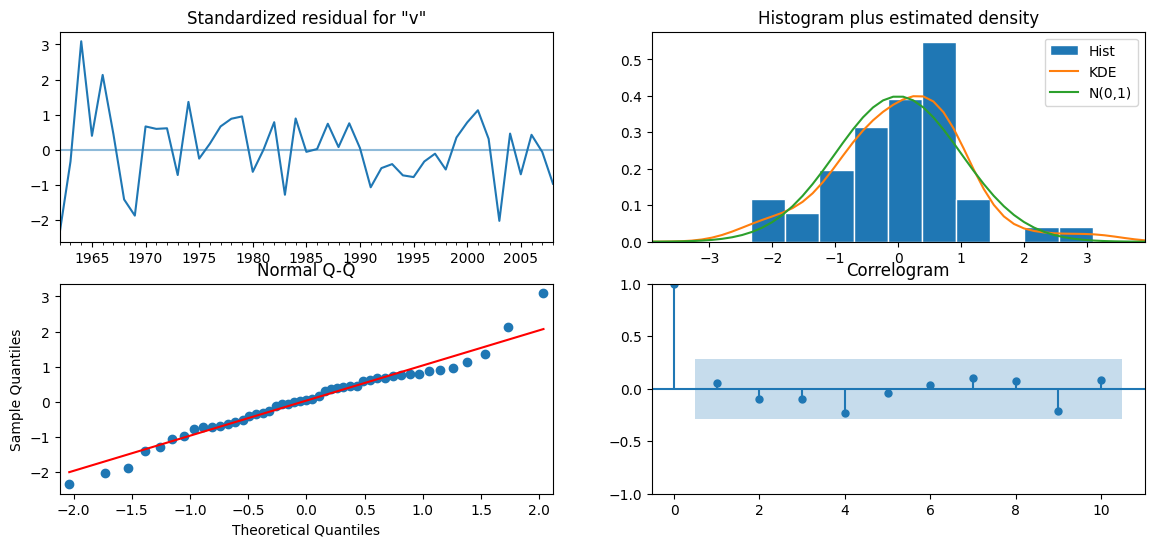

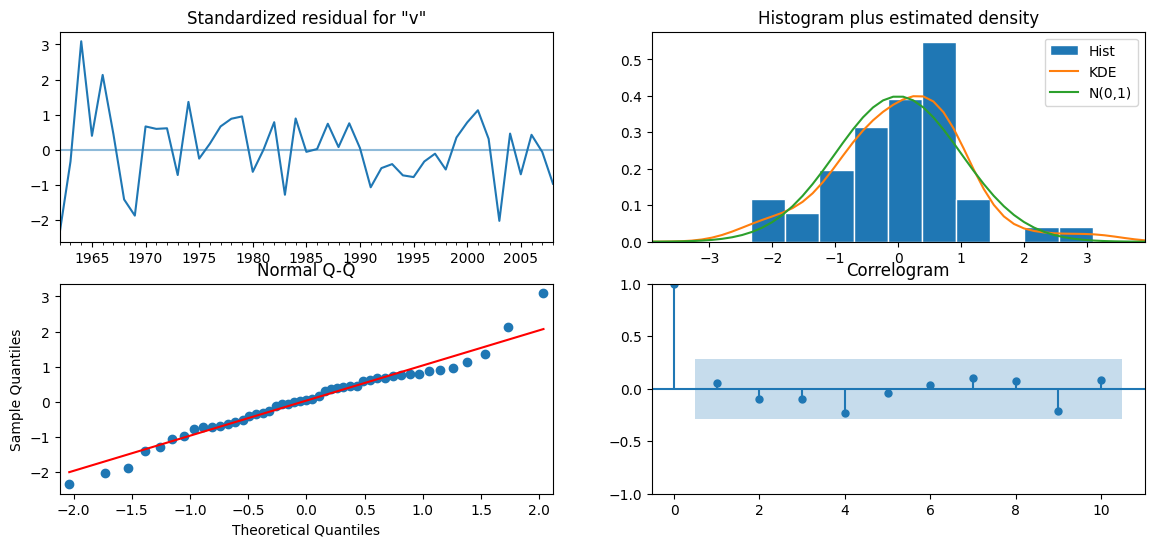

In [40]:
results.plot_diagnostics()

<Axes: xlabel='year'>

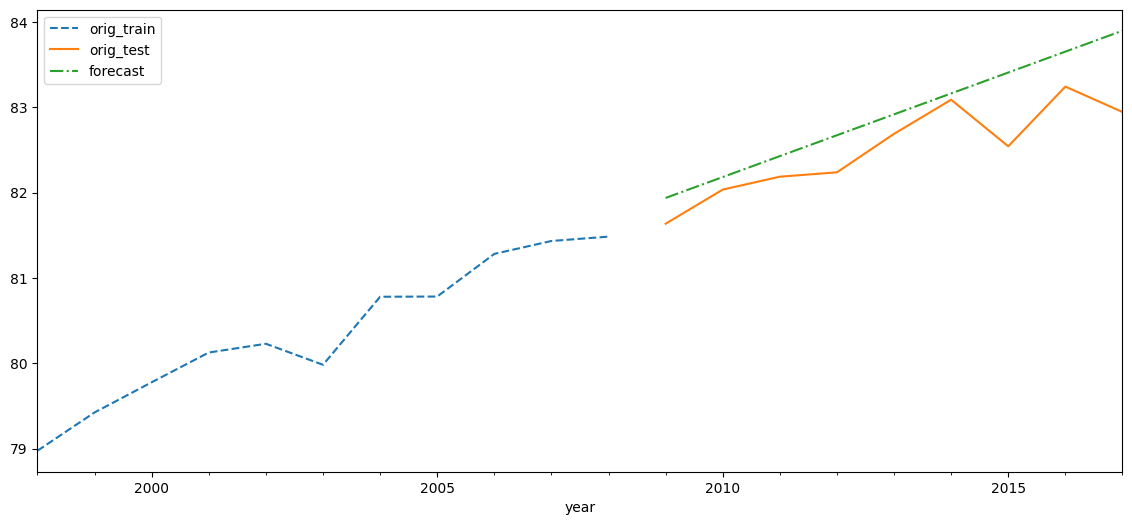

In [41]:
plot_forecast(results, '1998', life_train, life_test)


Let's apply the same steps to SARIMA in the `milk` dataset

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
plt.rcParams["figure.figsize"] = [14, 4]

<Axes: xlabel='month'>

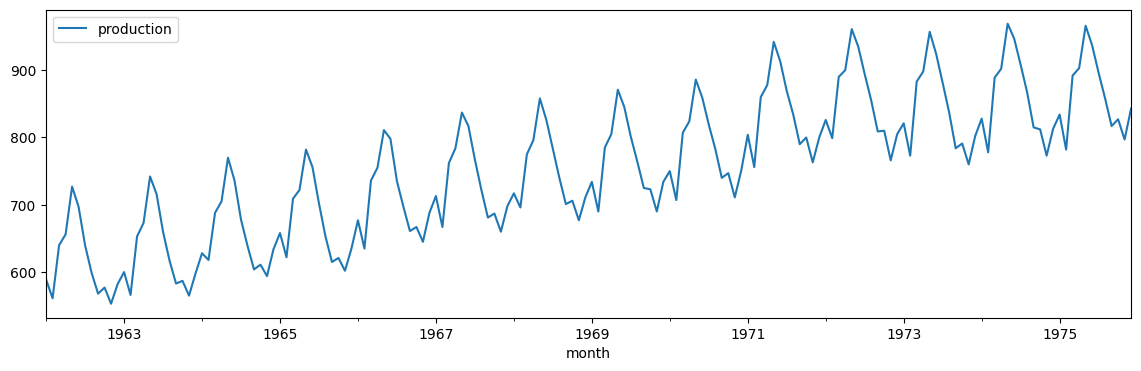

In [43]:
milk.plot()

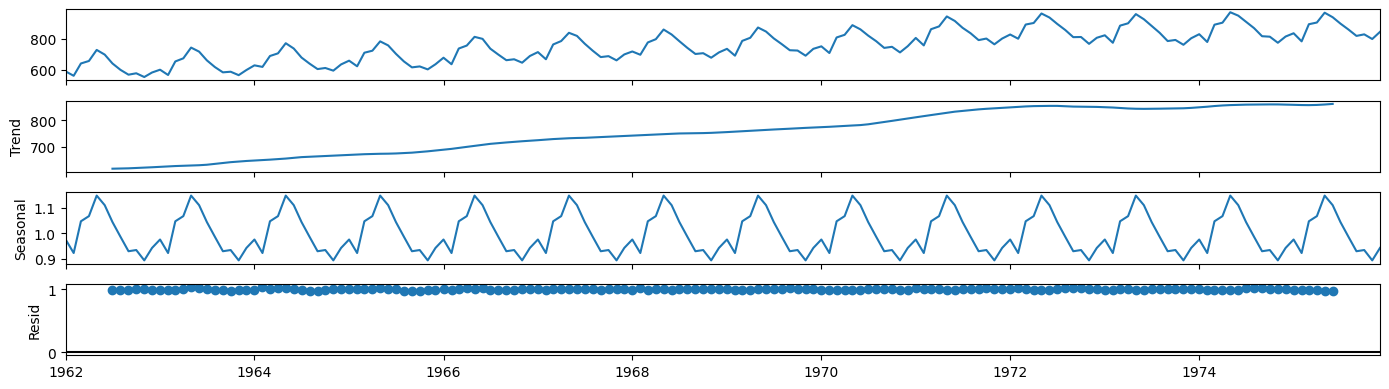

In [44]:
decomposed = seasonal_decompose(milk, period=12, model='multiplicative')
decomposed.plot(); plt.show()

In [45]:
milk_s = decomposed.seasonal

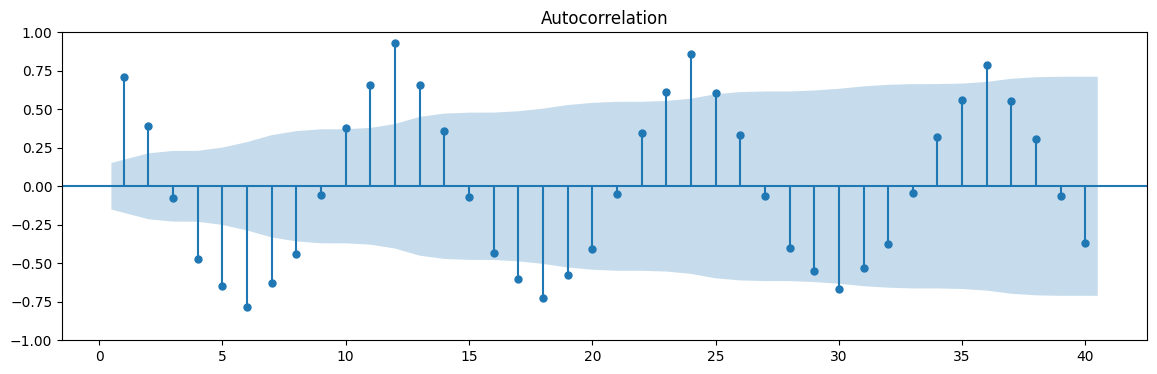

In [46]:
plot_acf(milk_s, zero=False, lags=40);plt.show()

In [47]:
milk_dif_12 = milk.diff(12).dropna()
milk_dif_12_1 = milk.diff(12).diff(1).dropna()


'Non-Stationary	 p-value:0.627426708603029 	 lags:13
'Non-Stationary	 p-value:0.16079880527711332 	 lags:12
'Stationary	 p-value:1.8654234318788898e-05 	 lags:11


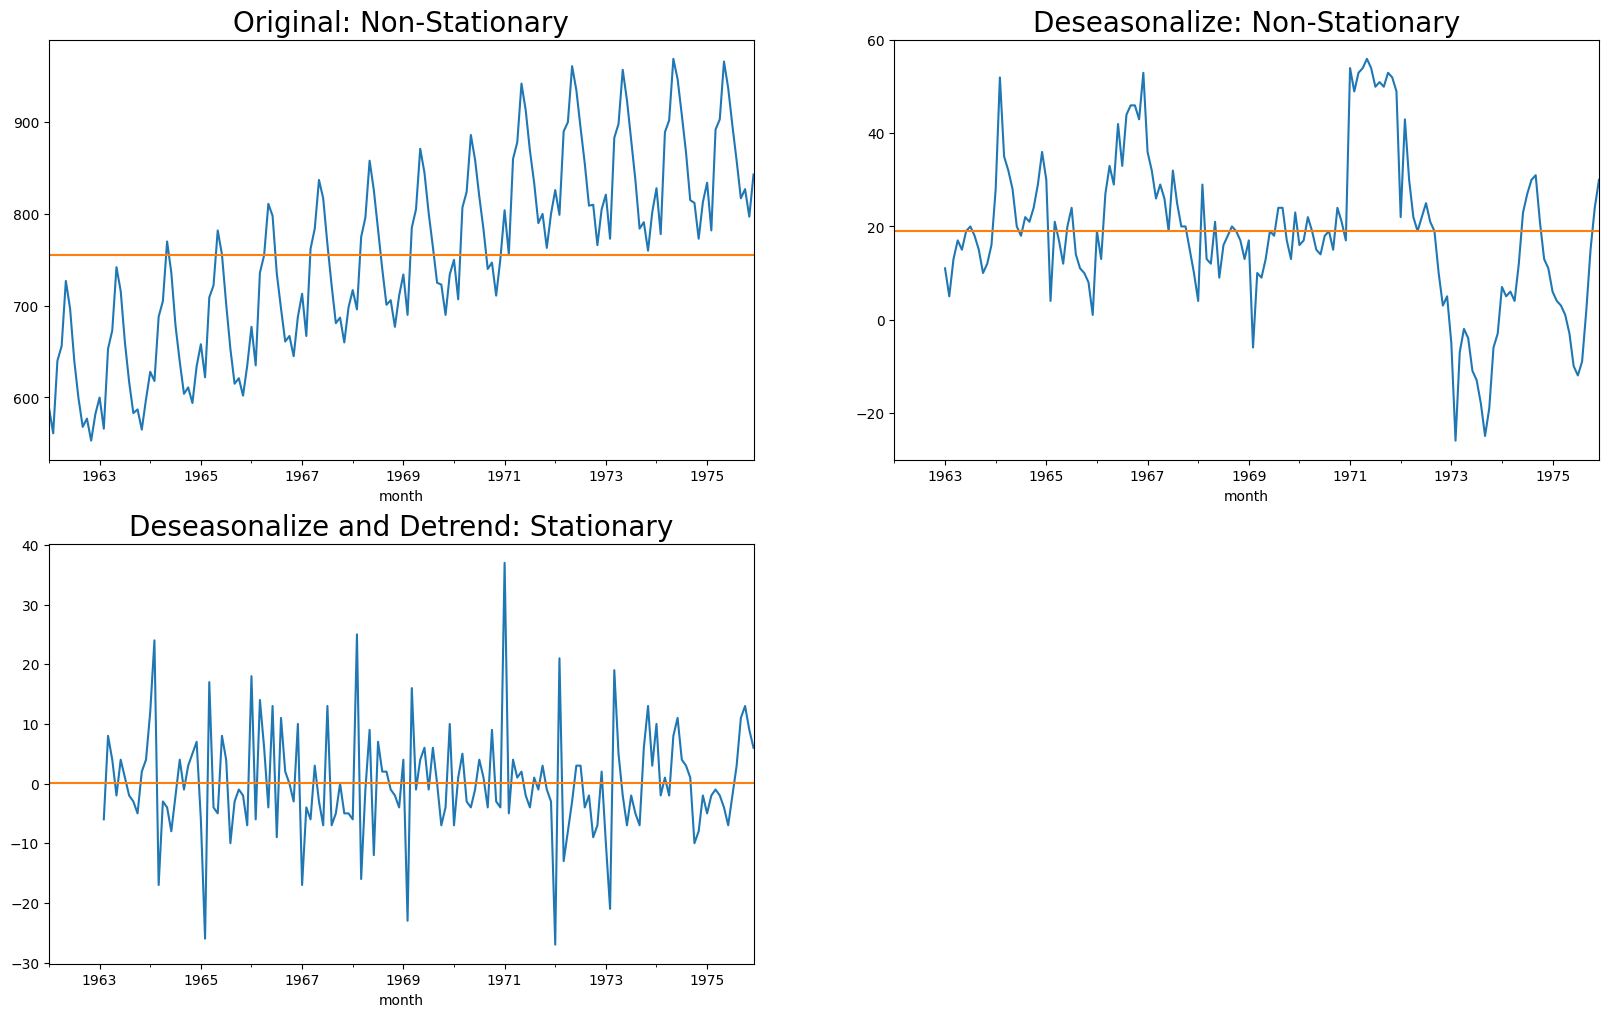

In [48]:
sets = [milk, milk_dif_12, milk_dif_12_1]
desc = ['Original', 'Deseasonalize', 'Deseasonalize and Detrend']
fig, ax = plt.subplots(2,2, figsize=(20,12))
index, l = milk.index, milk.shape[0]
for i, (d_set, d_desc) in enumerate(zip(sets, desc)):
    v, r = i // 2, i % 2
    outcome, pval = check_stationarity(d_set)
    d_set.plot(ax= ax[v,r], title=f'{d_desc}: {outcome}', legend=False)
    pd.Series(d_set.mean().values.tolist()*l, index=index).plot(ax=ax[v,r])
    ax[v,r].title.set_size(20)
ax[1,1].set_visible(False)
# plt.savefig('images/fig_10.21.png', bbox_inches='tight', dpi=300)
plt.show()

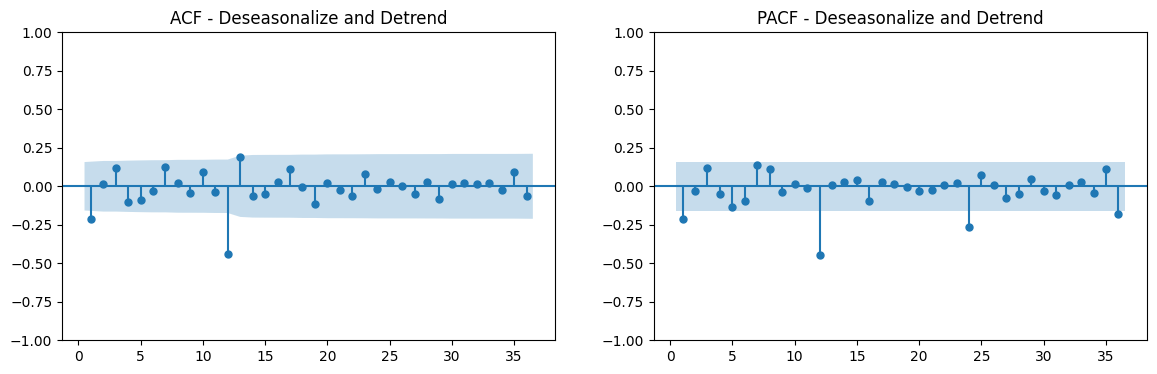

In [49]:
fig, ax = plt.subplots(1,2)
plot_acf(milk_dif_12_1, zero=False, lags=36, ax=ax[0], title=f'ACF - {d_desc}')
plot_pacf(milk_dif_12_1, zero=False, lags=36, ax=ax[1], title=f'PACF - {d_desc}')
plt.show()

[1, 12, 24, 36, 48]


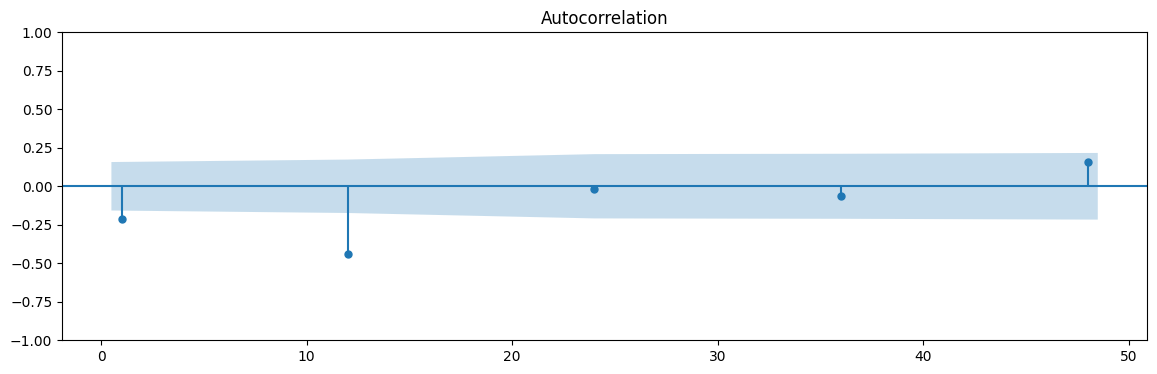

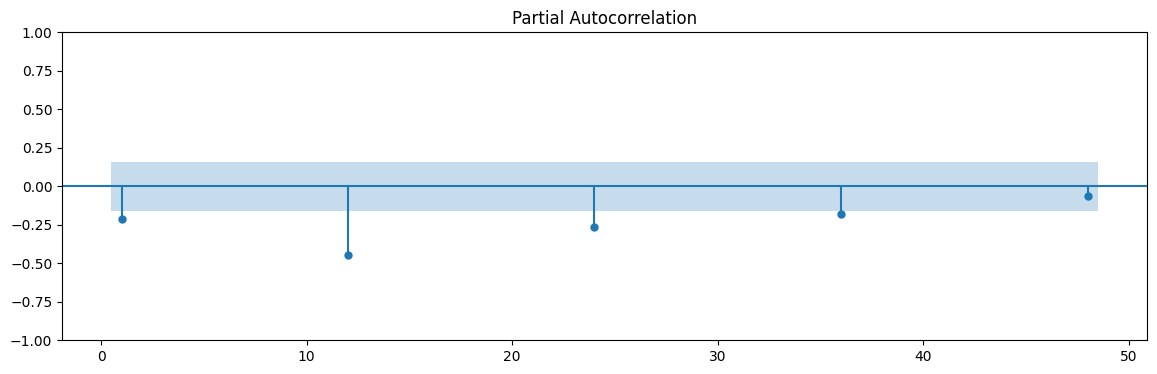

In [50]:
#lags = [1, 12, 24, 36, 48]
lags = [i for i in range(12, 60, 12)]
lags.insert(0, 1)
print(lags)
plot_acf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags)
plot_pacf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags);

In [51]:
sarima_model = SARIMAX(milk_train,
                       order=(0,1,1),
                       seasonal_order=(0,1,1,12))
model = sarima_model.fit(disp=0)


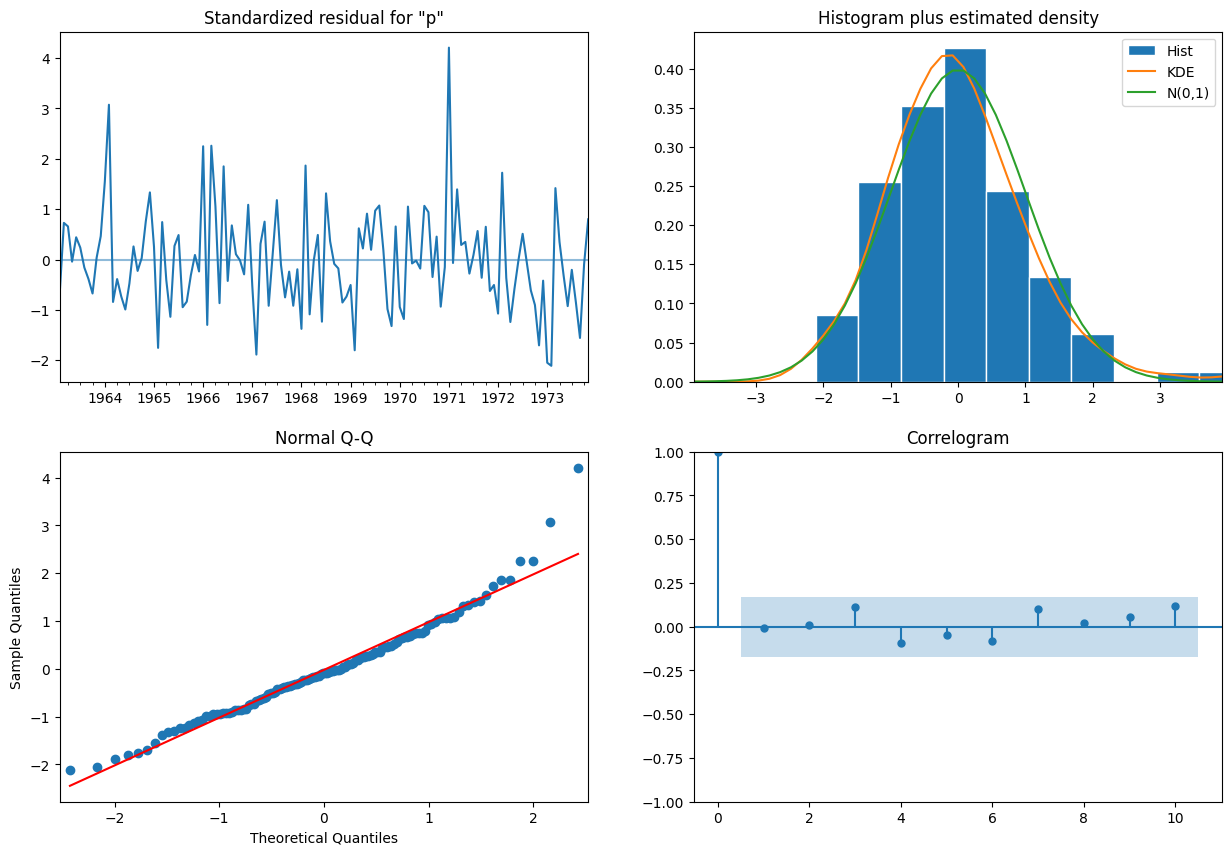

In [52]:
model.plot_diagnostics(figsize=(15,10))
# plt.savefig('images/fig_10.23.png', bbox_inches='tight', dpi=300)
plt.show()


In [54]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         production   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Tue, 04 Jun 2024   AIC                            903.335
Time:                                    18:51:38   BIC                            911.938
Sample:                                01-01-1962   HQIC                           906.831
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083   

<Axes: xlabel='month'>

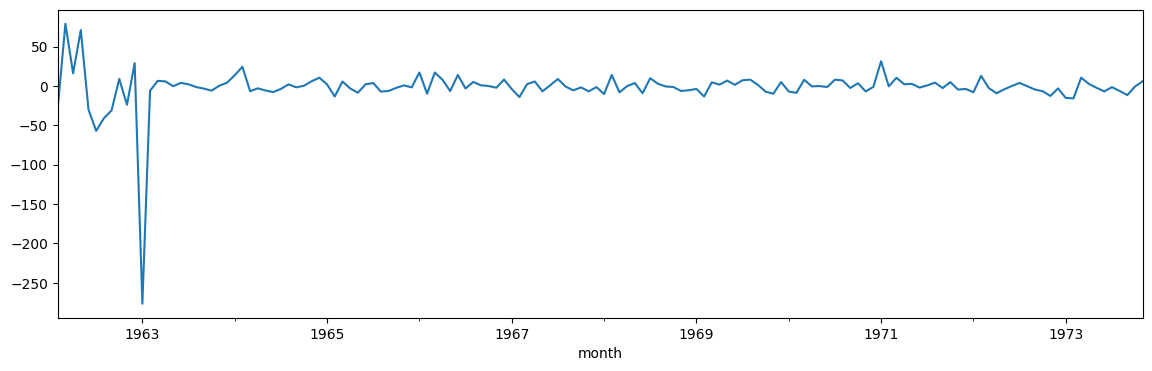

In [55]:
model.resid[1:].plot()

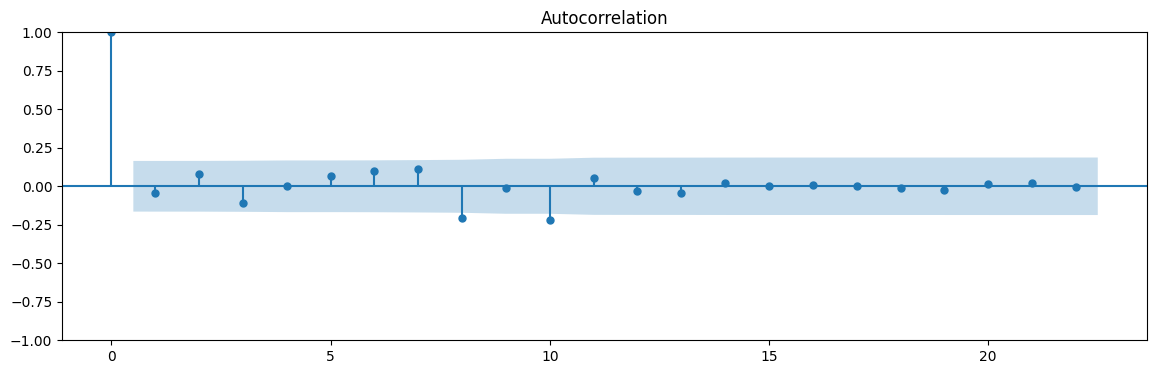

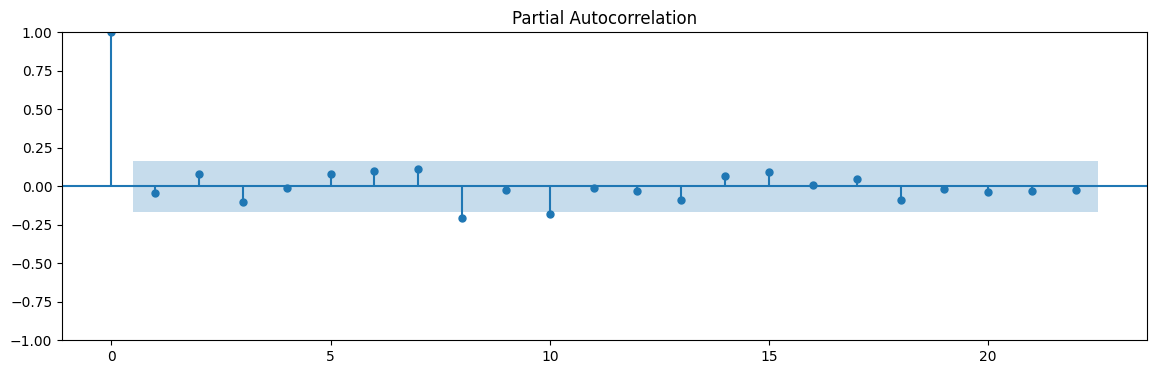

In [56]:
plot_acf(model.resid[1:])
plot_pacf(model.resid[1:]); plt.show()

<Axes: xlabel='month'>

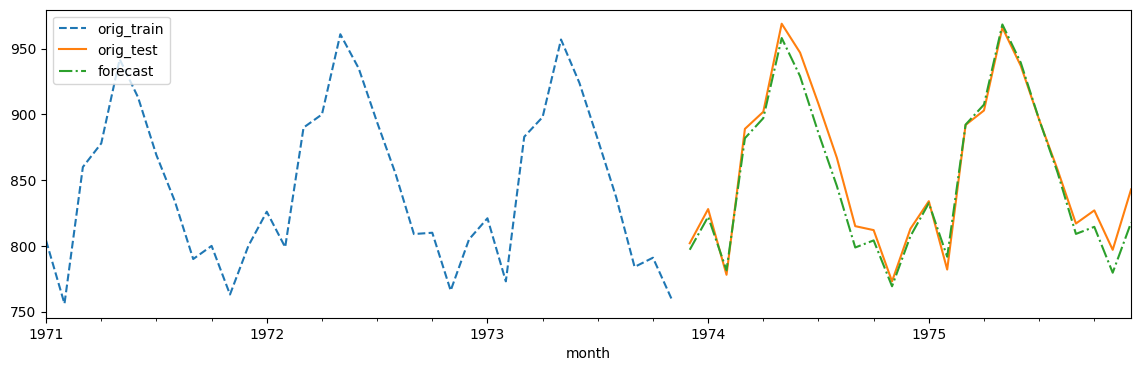

In [57]:
plot_forecast(model, '1971', milk_train, milk_test)

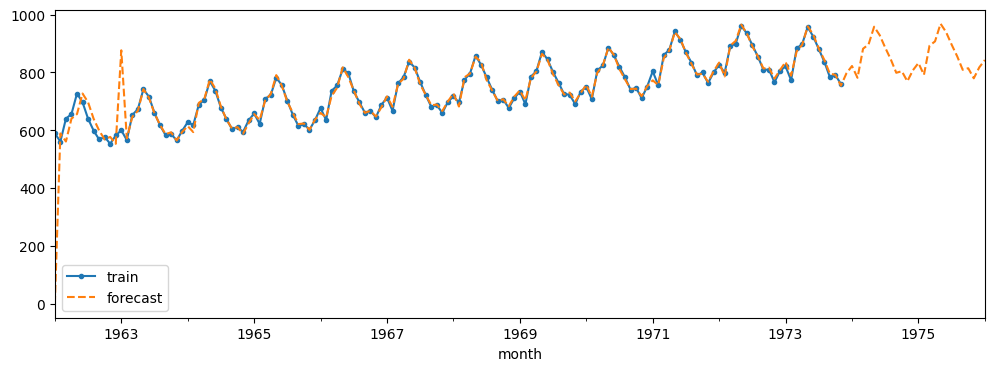

In [58]:
n = milk.shape[0]
milk_train.plot(style='.-', figsize=(12,4))
model.predict(end=n).plot(style='--')
plt.legend(['train', 'forecast'])

In [59]:
%%time
P_ns, D_ns, Q_ns = [list(range(3))]*3
P_s, D_s, Q_s = [list(range(2))]*3

vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {}
for i, (p, d, q, P, D, Q) in enumerate(vals):
    if i%15 == 0:
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},12)')
    m = SARIMAX(milk_train,
                order=(p,d,q),
                seasonal_order=(P, D, Q, 12),
                enforce_stationarity=False)
    res = m.fit(disp=0)
    y = milk_test.values.ravel()
    y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q),
                'seasonal order': (P, D, Q),
                'AIC':res.aic,
                'AICc': res.aicc,
                'BIC': res.bic,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

Running model #0 using SARIMA(0,0,0)(0,0,0,12)
Running model #15 using SARIMA(0,0,1)(1,1,1,12)
Running model #30 using SARIMA(0,1,0)(1,1,0,12)
Running model #45 using SARIMA(0,1,2)(1,0,1,12)
Running model #60 using SARIMA(0,2,1)(1,0,0,12)
Running model #75 using SARIMA(1,0,0)(0,1,1,12)
Running model #90 using SARIMA(1,0,2)(0,1,0,12)
Running model #105 using SARIMA(1,1,1)(0,0,1,12)
Running model #120 using SARIMA(1,2,0)(0,0,0,12)
Running model #135 using SARIMA(1,2,1)(1,1,1,12)
Running model #150 using SARIMA(2,0,0)(1,1,0,12)
Running model #165 using SARIMA(2,0,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,1)(1,0,0,12)
Running model #195 using SARIMA(2,2,0)(0,1,1,12)
Running model #210 using SARIMA(2,2,2)(0,1,0,12)
CPU times: user 1min 4s, sys: 2.88 s, total: 1min 7s
Wall time: 1min 35s


In [60]:
best_model = get_best_model(score, 'AIC')

Best model: 211 with lowest AIC score: 795.4217652642017


In [61]:
results = pd.DataFrame(score).T.sort_values(by='AIC').reset_index()
results.head(20)

,index,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
0,211,"(2, 2, 2)","(0, 1, 1)",795.421765,796.206812,811.838956,0.17819,15.135856,0.014454,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,67,"(0, 2, 2)","(0, 1, 1)",795.51592,795.882892,806.460713,0.328244,27.797583,0.028315,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,43,"(0, 1, 2)","(0, 1, 1)",796.763902,797.127539,807.743631,0.134089,11.487076,0.010387,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,191,"(2, 1, 2)","(1, 1, 1)",796.78823,797.834959,816.002754,0.112104,9.637867,0.009072,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,187,"(2, 1, 2)","(0, 1, 1)",796.876071,797.653849,813.345664,0.12826,10.998608,0.010075,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
5,139,"(1, 2, 2)","(0, 1, 1)",797.117088,797.672643,810.79808,0.289724,24.535187,0.024769,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
6,215,"(2, 2, 2)","(1, 1, 1)",797.418935,798.475539,816.572324,0.179536,15.248384,0.014583,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
7,115,"(1, 1, 2)","(0, 1, 1)",798.57341,799.123869,812.298071,0.1356,11.611921,0.010527,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
8,47,"(0, 1, 2)","(1, 1, 1)",798.638183,799.188641,812.362843,0.133006,11.396138,0.010312,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
9,71,"(0, 2, 2)","(1, 1, 1)",798.88124,799.436795,812.562232,0.427696,36.195338,0.03686,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [62]:
results = pd.DataFrame(score).T.sort_values(by='BIC').reset_index()
results.head(20)


,index,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
0,67,"(0, 2, 2)","(0, 1, 1)",795.51592,795.882892,806.460713,0.328244,27.797583,0.028315,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,43,"(0, 1, 2)","(0, 1, 1)",796.763902,797.127539,807.743631,0.134089,11.487076,0.010387,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,35,"(0, 1, 1)","(0, 1, 1)",802.462674,802.676959,810.723444,0.13409,11.489677,0.01037,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,139,"(1, 2, 2)","(0, 1, 1)",797.117088,797.672643,810.79808,0.289724,24.535187,0.024769,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,211,"(2, 2, 2)","(0, 1, 1)",795.421765,796.206812,811.838956,0.17819,15.135856,0.014454,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
5,115,"(1, 1, 2)","(0, 1, 1)",798.57341,799.123869,812.298071,0.1356,11.611921,0.010527,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
6,47,"(0, 1, 2)","(1, 1, 1)",798.638183,799.188641,812.362843,0.133006,11.396138,0.010312,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
7,71,"(0, 2, 2)","(1, 1, 1)",798.88124,799.436795,812.562232,0.427696,36.195338,0.03686,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
8,187,"(2, 1, 2)","(0, 1, 1)",796.876071,797.653849,813.345664,0.12826,10.998608,0.010075,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
9,131,"(1, 2, 1)","(0, 1, 1)",802.770371,803.134007,813.7501,0.205811,17.44995,0.016939,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [63]:
score[211]

{'non-seasonal order': (2, 2, 2),
 'seasonal order': (0, 1, 1),
 'AIC': 795.4217652642017,
 'AICc': 796.2068119931737,
 'BIC': 811.8389559545686,
 'RMSPE': 0.17818982955154078,
 'RMSE': 15.135855841260854,
 'MAPE': 0.014454255676846793,
 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2ac07fd60>}

<Axes: xlabel='month'>

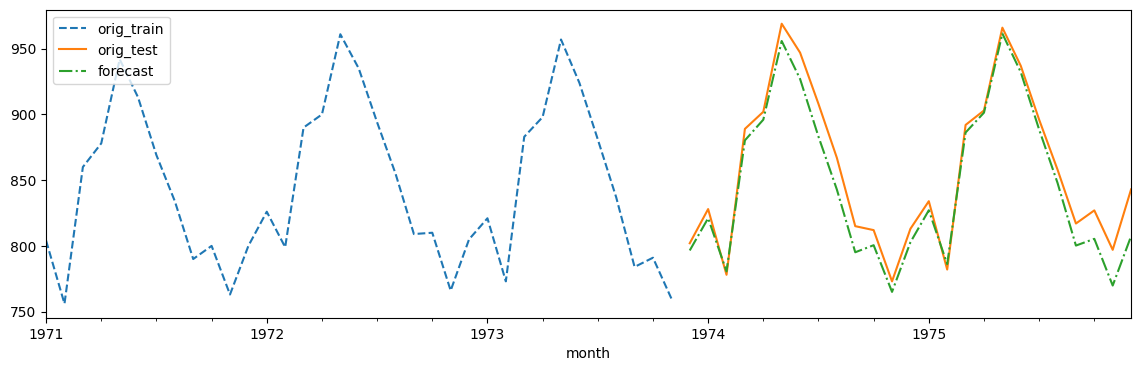

In [64]:
plot_forecast(best_model, '1971', milk_train, milk_test)